In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from glob import glob
import torch.nn.functional as F


In [2]:
"""
Screw Defect Detection using Anomaly Detection
=============================================================

Approach:
- Train autoencoder only on good screws
- Model learns to reconstruct normal screws
- Defective screws have high reconstruction error
- Use reconstruction error as anomaly score
"""

'\nScrew Defect Detection using Anomaly Detection\n=============================================================\n\nApproach:\n- Train autoencoder only on good screws\n- Model learns to reconstruct normal screws\n- Defective screws have high reconstruction error\n- Use reconstruction error as anomaly score\n'

In [20]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration for Macbook M1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [4]:
# DATASET CONFIGURATION

# Update this path to where you extracted the screw dataset
DATASET_PATH = "screw_dataset/" 

# Dataset structure
TRAIN_GOOD_PATH = os.path.join(DATASET_PATH, "train", "good")
TEST_GOOD_PATH = os.path.join(DATASET_PATH, "test", "good")
TEST_DEFECT_PATH = os.path.join(DATASET_PATH, "test")

In [5]:
# Check if paths exist
print("\n" + "="*60)
print("Checking dataset paths...")
print("="*60)

if os.path.exists(TRAIN_GOOD_PATH):
    n_train = len(os.listdir(TRAIN_GOOD_PATH))
    print(f"  Training samples: {n_train}")
else:
    print(f"✗ Training path NOT found: {TRAIN_GOOD_PATH}")
    print("  Please update DATASET_PATH!")

if os.path.exists(TEST_GOOD_PATH):
    n_test_good = len(os.listdir(TEST_GOOD_PATH))
    print(f"  Good test samples: {n_test_good}")
else:
    print(f"✗ Test path NOT found")


Checking dataset paths...
  Training samples: 320
  Good test samples: 41


In [6]:
def explore_dataset(test_path):
    """Explore the test dataset to see what defect types exist."""
    
    print("\n" + "="*60)
    print("Defect Types in Test Set")
    print("="*60)
    
    # List all subdirectories in test folder
    defect_types = []
    for item in os.listdir(test_path):
        item_path = os.path.join(test_path, item)
        if os.path.isdir(item_path):
            n_samples = len(os.listdir(item_path))
            defect_types.append((item, n_samples))
    
    # Sort by name
    defect_types.sort()
    
    # Print summary
    for defect_name, count in defect_types:
        status = "✓ Normal" if defect_name == "good" else "✗ Defect"
        print(f"  {status}: {defect_name:20s} - {count} samples")
    
    return defect_types

# Run exploration
if os.path.exists(TEST_DEFECT_PATH):
    defect_info = explore_dataset(TEST_DEFECT_PATH)


Defect Types in Test Set
  ✓ Normal: good                 - 41 samples
  ✗ Defect: manipulated_front    - 24 samples
  ✗ Defect: scratch_head         - 24 samples
  ✗ Defect: scratch_neck         - 25 samples
  ✗ Defect: thread_side          - 23 samples
  ✗ Defect: thread_top           - 23 samples



GOOD SCREWS (Training Data)


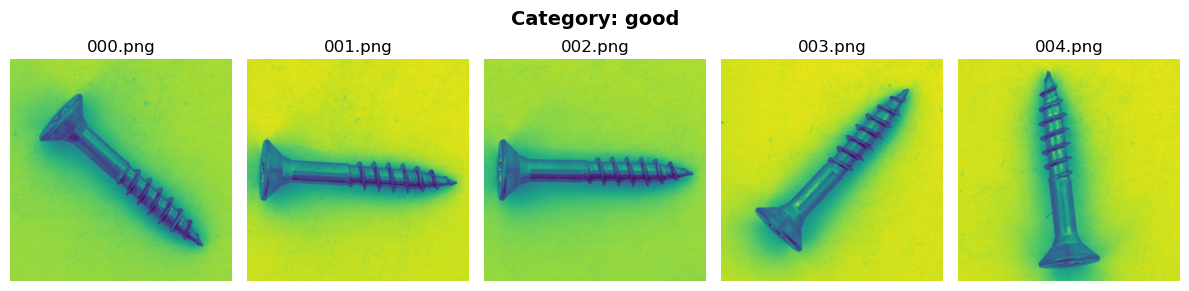


DEFECT TYPES (Test Data)


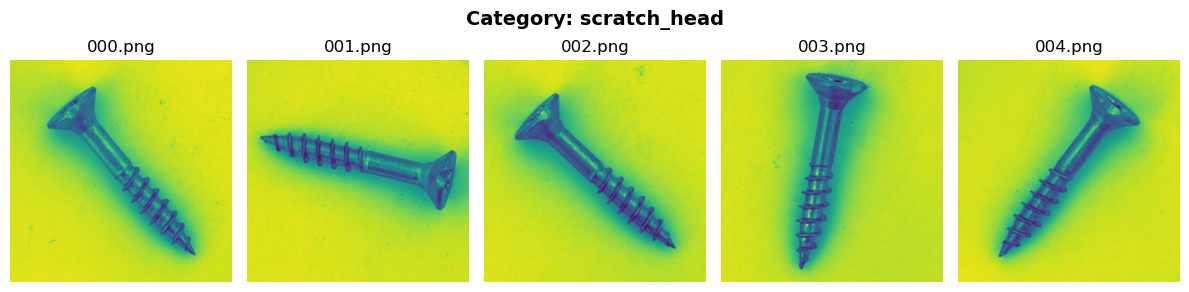

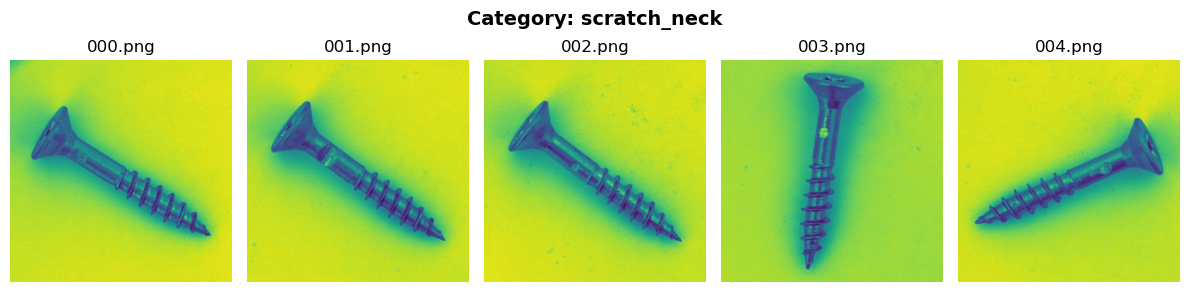

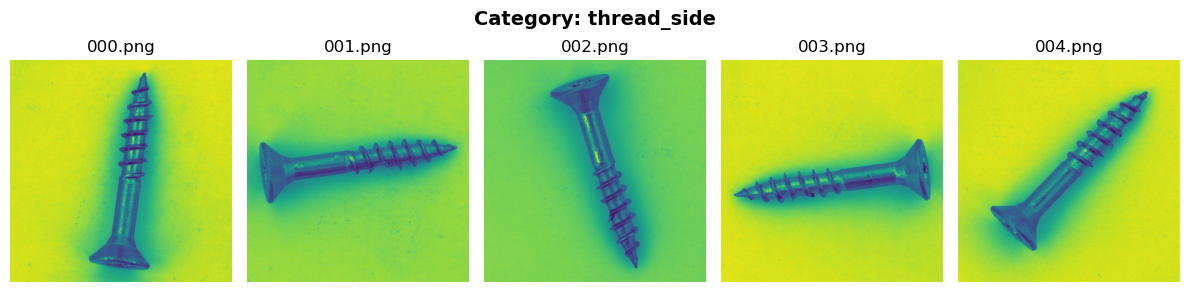

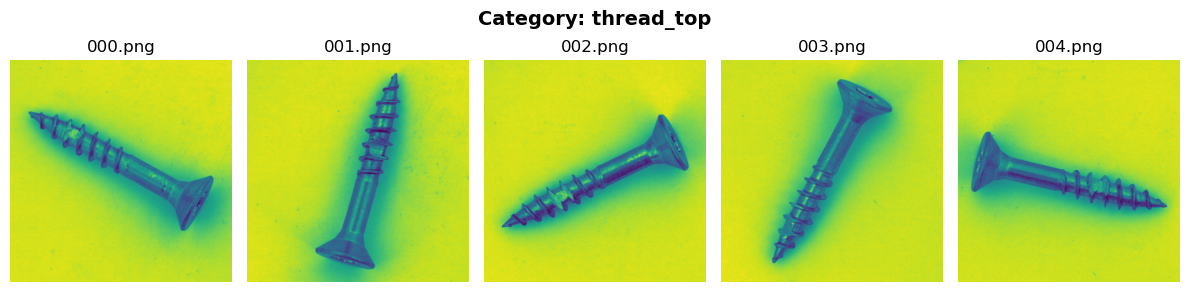

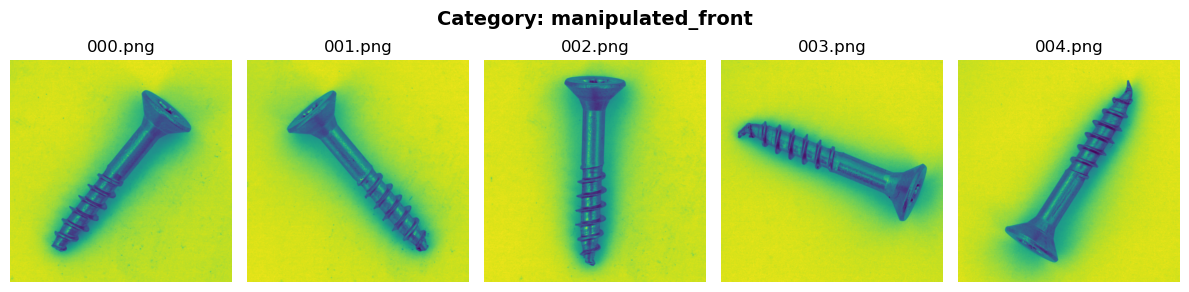

In [7]:
# ============================================
# VISUALIZE SAMPLES
# ============================================

def visualize_samples(dataset_path:str, category:str, num_samples=5):
    """
    Visualize sample images from a category.
    """
    category_path = os.path.join(dataset_path, "test", category)
    
    # Get num_samples of images depending on the category
    image_files = sorted(os.listdir(category_path))[:num_samples]
    
    # Plot
    fig, axes = plt.subplots(nrows= 1, ncols=num_samples, figsize=(12, 3))
    fig.suptitle(f'Category: {category}', fontsize=14, fontweight='bold')
    
    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path)
        
        if num_samples == 1:
            axes.imshow(img)
            axes.axis('off')
            axes.set_title(img_file)
        else:
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(img_file)
    
    plt.tight_layout()
    plt.show()

# Visualize good screws (
print("\n" + "="*60)
print("GOOD SCREWS (Training Data)")
print("="*60)
visualize_samples(DATASET_PATH, "good", num_samples=5)

# Visualize each defect type
print("\n" + "="*60)
print("DEFECT TYPES (Test Data)")
print("="*60)

# Show examples of each defect
defect_categories = ["scratch_head", "scratch_neck", "thread_side", 
                     "thread_top", "manipulated_front"]

for defect_type in defect_categories:
    visualize_samples(DATASET_PATH, defect_type, num_samples=5)

In [8]:
# Looking at image properties
sample_files = os.listdir(TRAIN_GOOD_PATH)[:1]
    
sizes = []
for img_file in sample_files:
    img = Image.open(os.path.join(TRAIN_GOOD_PATH, img_file))
    sizes.append(img.size)
    print(f"Sample image: {img_file}")
    print(f"  Size: {img.size} (width × height)")
    print(f"  Mode: {img.mode}")


Sample image: 176.png
  Size: (1024, 1024) (width × height)
  Mode: L


Observations: 
- Images have one channel (L) 
- Image size is 1024 x 1024 -> needs to resize 


In [9]:
class ScrewAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            # 256x256x1 → 128x128x32
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 128x128x32 → 64x64x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 64x64x64 → 32x32x128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 32x32x128 → 16x16x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 16x16x256 → 8x8x512
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # 8x8x512 → 4x4x512
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        
        self.decoder = nn.Sequential(
            # 4x4x512 → 8x8x512
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # 8x8x512 → 16x16x256
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 16x16x256 → 32x32x128
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 32x32x128 → 64x64x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 64x64x64 → 128x128x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 128x128x32 → 256x256x1
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [10]:
# Create model
model = ScrewAutoencoder().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"Total parameters: {total_params:,}")
print("="*60)

# Print model structure
print("\nModel structure:")
print(model)


MODEL ARCHITECTURE
Total parameters: 7,860,097

Model structure:
ScrewAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, m

In [11]:
# ============================================
# DATA LOADING 
# ============================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

# ============================================
# Define Transforms
# ============================================

transform = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize 1024×1024 → 256x256
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),            
])

print("Transforms defined")



LOADING DATA
Transforms defined


In [12]:
# Load and transform images

# Training dataset (only good screws)
train_dataset = ImageFolder(
    root="screw_dataset/train",  # Points to directory containing "good" folder
    transform=transform
)

# Test dataset (good screws)
test_dataset = ImageFolder(
    root="screw_dataset/test",   # Contains "good" and defect folders
    transform=transform
)

# Create DataLoaders

BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("\n" + "="*60)
print("DATALOADERS CREATED")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("="*60)


DATALOADERS CREATED
Batch size: 16
Training batches: 20
Test batches: 10


In [13]:
# ============================================
# TRAINING SETUP

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 100


In [14]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_images, _ in train_loader:
            batch_images = batch_images.to(device)
            
            reconstructed = model(batch_images)
            loss = criterion(reconstructed, batch_images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")
    
    print("\nTraining complete!")
    return train_losses

In [23]:
train_losses = train_autoencoder(model, train_loader, criterion, optimizer, NUM_EPOCHS, device)

KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, test_loader, device, patch_size=14):
    model.eval()
    errors = []
    labels = []
    
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images = batch_images.to(device)
            reconstructed = model(batch_images)
            
            # Per-pixel squared error
            diff = (batch_images - reconstructed) ** 2
            
            # Max error in local patches
            patches = F.max_pool2d(diff, kernel_size=patch_size)
            max_errors = patches.view(patches.size(0), -1).max(dim=1)[0]
            
            errors.extend(max_errors.cpu().numpy())
            labels.extend(batch_labels.numpy())
            
            if device.type == "mps":
                torch.mps.synchronize()
    
    return np.array(errors), np.array(labels)

In [ ]:
errors, labels = evaluate_model(model, test_loader, device)

NameError: name 'model' is not defined

In [ ]:
# Label 0 = good, everything else = defect
good_errors = errors[labels == 0]
defect_errors = errors[labels != 0]


NameError: name 'errors' is not defined

In [ ]:
for defect_type, name in test_dataset.class_to_idx.items():
    type_errors = errors[labels == name]
    if len(type_errors) > 0:
        print(f"{defect_type:20s} - Mean error: {np.mean(type_errors):.6f}")

good                 - Mean error: 0.008295
manipulated_front    - Mean error: 0.011988
scratch_head         - Mean error: 0.012007
scratch_neck         - Mean error: 0.012144
thread_side          - Mean error: 0.009528
thread_top           - Mean error: 0.015798


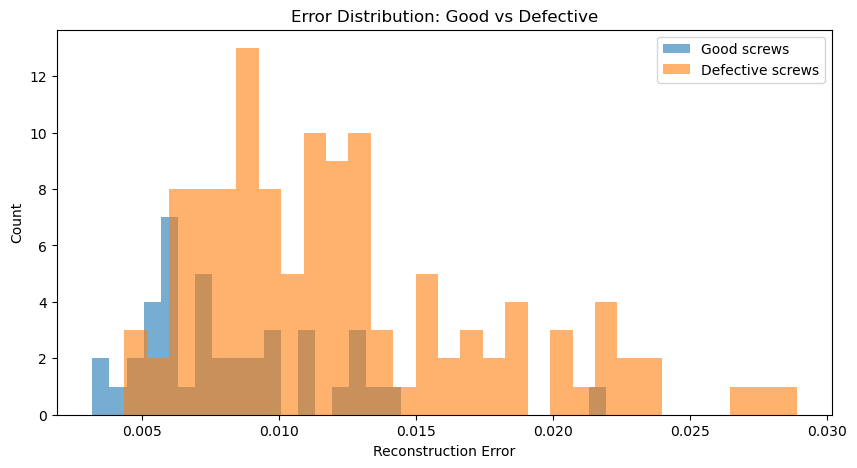

In [ ]:
# Plot error distribution
plt.figure(figsize=(10, 5))
plt.hist(good_errors, bins=30, alpha=0.6, label='Good screws')
plt.hist(defect_errors, bins=30, alpha=0.6, label='Defective screws')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Error Distribution: Good vs Defective')
plt.legend()
plt.show()

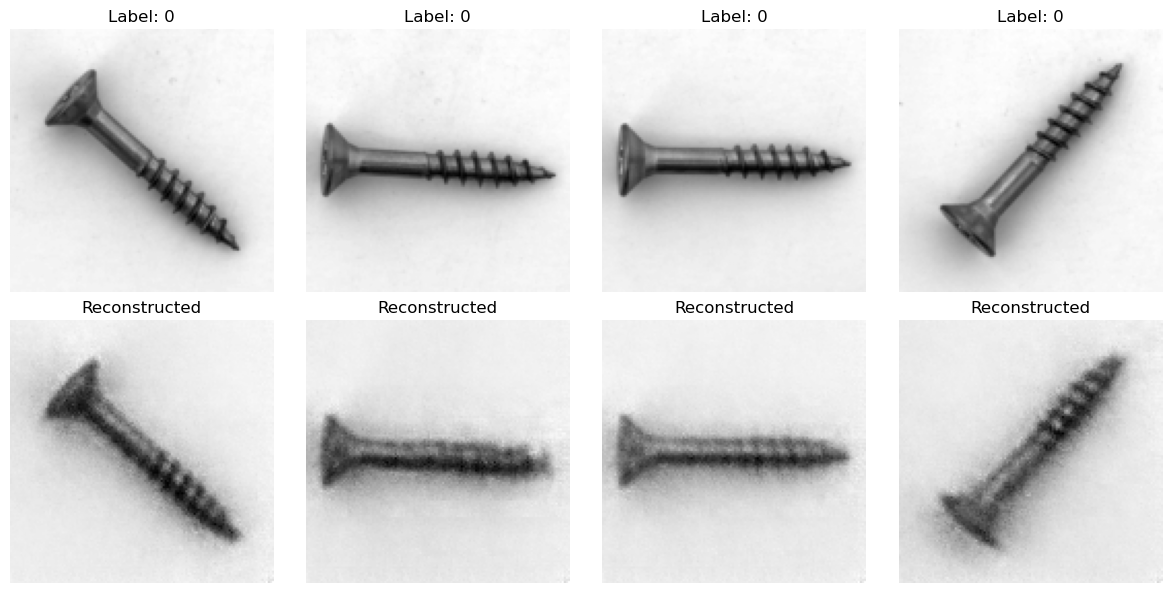

In [ ]:
model.eval()
with torch.no_grad():
    # Get one batch
    images, batch_labels = next(iter(test_loader))
    images = images.to(device)
    reconstructed = model(images)

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        # Original
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Label: {batch_labels[i].item()}")
        axes[0, i].axis('off')
        
        # Reconstruction
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.tight_layout()
    plt.show()